# Importing Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, f1_score, roc_curve,auc
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.simplefilter('ignore', FitFailedWarning)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Importing Dataset

In [3]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [4]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# No Missing Values

In [5]:
df.isna().any().any()

False

# Encoding Categorical Values

In [6]:
#Columns with string values
categorical_column = ['Attrition', 'BusinessTravel', 'Department','Gender', 'JobRole', 'MaritalStatus', 'OverTime','EducationField']
encoder=LabelEncoder()
df[categorical_column]=df[categorical_column].apply(encoder.fit_transform)

# Seperating into X and y

In [7]:
y=df['Attrition']
X=df.drop(['EmployeeCount','Attrition','EmployeeNumber','Over18','StandardHours'],axis=1)

In [8]:
rus = RandomUnderSampler(random_state=42,replacement=True)
X_, y = rus.fit_resample(X,y)
X = pd.DataFrame(X_,columns=X.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Spliting into Train and Test Sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

### Sample Row

In [10]:
X_train.iloc[0].to_dict()

{'Age': 37,
 'BusinessTravel': 1,
 'DailyRate': 663,
 'Department': 1,
 'DistanceFromHome': 11,
 'Education': 3,
 'EducationField': 4,
 'EnvironmentSatisfaction': 2,
 'Gender': 1,
 'HourlyRate': 47,
 'JobInvolvement': 3,
 'JobLevel': 3,
 'JobRole': 5,
 'JobSatisfaction': 4,
 'MaritalStatus': 0,
 'MonthlyIncome': 12185,
 'MonthlyRate': 10056,
 'NumCompaniesWorked': 1,
 'OverTime': 1,
 'PercentSalaryHike': 14,
 'PerformanceRating': 3,
 'RelationshipSatisfaction': 3,
 'StockOptionLevel': 3,
 'TotalWorkingYears': 10,
 'TrainingTimesLastYear': 1,
 'WorkLifeBalance': 3,
 'YearsAtCompany': 10,
 'YearsInCurrentRole': 8,
 'YearsSinceLastPromotion': 0,
 'YearsWithCurrManager': 7}

# Hyper-parameter Tuning Using Grid Search CV

In [11]:
def tune_hyperparameters(model,X,y):
  param_grid = {"solver":['svd', 'lsqr', 'eigen'], "shrinkage":['auto',0.1,0.01,1,0]}
  grid_search = GridSearchCV(model,param_grid=param_grid,scoring='accuracy')
  grid_search.fit(X,y)
  print("Best Params: ",grid_search.best_params_)
  return grid_search.best_params_

In [12]:
best_params = tune_hyperparameters(LinearDiscriminantAnalysis(),X_train,y_train)
best_params

Best Params:  {'shrinkage': 0, 'solver': 'lsqr'}


{'shrinkage': 0, 'solver': 'lsqr'}

# Performing Linear Discrimant Analysis

In [13]:
def train_predict_evaluate(model,X_train,y_train,X_test):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  print("Accuracy: ",accuracy_score(y_test,y_pred))
  print("Precision: ",precision_score(y_test,y_pred,zero_division=0))
  print("Recall: ",recall_score(y_test,y_pred,zero_division=0))
  print("F1 Score: ",f1_score(y_test,y_pred,zero_division=0))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

  
  fpr,tpr,thresholds = roc_curve(y_test,y_pred)
  plt.plot(fpr, tpr,color='green',label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
  plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("ROC Curve")
  plt.legend(loc="lower right")
  plt.show()

Accuracy:  0.7272727272727273
Precision:  0.7368421052631579
Recall:  0.7466666666666667
F1 Score:  0.7417218543046358
Confusion Matrix:
 [[48 20]
 [19 56]]


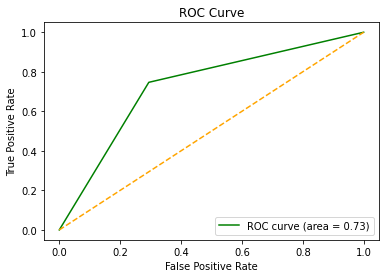

In [14]:
train_predict_evaluate(LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'),X_train,y_train,X_test)

# K-Fold Cross Validation

In [15]:
def cross_validation(model,X,y):
  scores = cross_validate(model, X, y, cv=5,scoring=('accuracy','precision','recall','f1'))

  metrics = []
  metrics.append(np.mean(scores['test_accuracy']))
  metrics.append(np.mean(scores['test_precision']))
  metrics.append(np.mean(scores['test_recall']))
  metrics.append(np.mean(scores['test_f1']))

  print("Accuracy: ",metrics[0])
  print("Precision: ",metrics[1])
  print("Recall: ",metrics[2])
  print("F1 Score: ",metrics[3])

  return metrics

In [16]:
metrics = []

In [17]:
metrics.append(cross_validation(LinearDiscriminantAnalysis(**best_params),X,y))

Accuracy:  0.7320044792833146
Precision:  0.7317535250167164
Recall:  0.7515070921985816
F1 Score:  0.7376020045007469


# Performance

In [18]:
mdf = pd.DataFrame(metrics,columns=["Accuracy","Precision","Recall","F1 Score"])
mdf.head()

,Accuracy,Precision,Recall,F1 Score
0,0.732004,0.731754,0.751507,0.737602
